<a href="https://colab.research.google.com/github/eitellauria/Retention/blob/main/Freshmen_Retention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freshmen_Retention


In [1]:
!pip install fancyimpute --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!ls /gdrive/MyDrive/Research/Retention/RetentionCommittee/Legacy

retentionAugmented2016.csv  test_S2_withS1_LogReg.csv	train_S2_withS1_XGBoost.csv
retentionAugmented2017.csv  test_S2_withS1_XGBoost.csv
retentionAugmented2018.csv  train_S2_withS1_LogReg.csv


In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
#from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from fancyimpute import KNN

#from bayes_opt import BayesianOptimization

## Execution parameters

In [5]:
#datapth
datapath = '/gdrive/MyDrive/Research/Retention/RetentionCommittee/Legacy/'

#output path
outputpath =  '/gdrive/MyDrive/Research/Retention/RetentionCommittee/Legacy/'

# Semester
semester = 1

# Impute
impute = True

# Balance data through weighted classes
balance = False

# Columns to normalize
#normalizationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_BLDG", "OCCUPANTS_ROOM"]
#normalizationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_ROOM"]

# Columns to impute
# Columns with nulls:
# Significantly filled with nulls, so don't impute: HSClassPercentile, APTITUDE_SCORE
#imputationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_BLDG", "OCCUPANTS_ROOM"]
#imputationColumns = ["FinAidRating", "DISTANCE_IN_MILES",  "OCCUPANTS_ROOM"]
imputationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_BLDG", "OCCUPANTS_ROOM", "APTITUDE_SCORE"]

# Number of Iterations in Bayesian optimization
ITERATIONS = 20 # 100

# Training File Name
trainName = 'retentionAugmented2016.csv'
train_namelist = ['retentionAugmented2016.csv','retentionAugmented2017.csv']

# Testing File Name
testName = 'retentionAugmented2018.csv'

After executing the cell above, a new file named 'Sample file.txt' will appear in your [drive.google.com](https://drive.google.com/) file list.

## Helper Functions

In [353]:
def read_traning_data (datapath, namelist):
    for i,filename in enumerate(namelist):
        print(filename)
        if i==0:
           dfr  = pd.read_csv(datapath+filename).drop(['AdmissionYear'], axis=1)
        else:
           #dfx  = pd.read_csv(datapath+trainName).drop(['AdmissionYear'], axis=1)
           dfr  = pd.concat([dfr, pd.read_csv(datapath+trainName).drop(['AdmissionYear'], axis=1)], ignore_index=True)
    return dfr
#------------------------------------------------------------------------------------------------------------------------------
def CustomKNNImpute (df,df_types, k_neighbors=3):
    """ Replace the missing values within the value coming from the k neighbors
        Assumes that the dataframe is made up of numerical values which are either floating point ('f'), binary flags ('b'), or multi_category ('c')
        These data types should be provided as a dictionary (df_types) which can be created with the statement:
          df_types = dict(zip(df.columns.to_list(), list_of_data_types))
        For example:
          df_types = dict(zip(df.columns.to_list(), ['b','b','b','f','f','c']))

        @params:
            - df                            = a dataframe to be imputed
            - df_types                      = a dictionary of datatypes, indexed by the column names
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
        @returns:
             - df_imputed                   = the imputed dataframe
    """
    #from sklearn.impute import KNNImputer
    #imputer = KNNImputer(n_neighbors=k_neighbors)

    imputer = KNN(k=k_neighbors)   # using fancyimputer instead

    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns= df.columns)

    for x in df_types:
     if df_types[x] in ['b','c']:
        df_imputed[x]=df_imputed[x].round(decimals=0)

    return df_imputed
#----------------------------------------------------------------------------------------------------------------------------------------------
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr, pearsonr

def phi_coefficient(x, y):
    # A simplified Phi coefficient calculation assuming binary variables coded as 0 and 1
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = len(x)
    phi = np.sqrt(chi2 / n)
    return phi

def calculate_correlation(x, y):
    if set(x.unique()) == {0, 1} and set(y.unique()) == {0, 1}: # Both binary
        return phi_coefficient(x, y)
    elif set(x.unique()) == {0, 1} or set(y.unique()) == {0, 1}: # One binary, one continuous
        return pointbiserialr(x, y)[0]
    else: # Both continuous
        return pearsonr(x, y)[0]

def mixed_type_correlation_matrix(data):
    corr_matrix = pd.DataFrame(index=data.columns, columns=data.columns, dtype=float)
    for col1 in data.columns:
        for col2 in data.columns:
            if data[col1].dtype == 'O' or data[col2].dtype == 'O': # Skip non-numeric columns
                corr_matrix.loc[col1, col2] = np.nan
            else:
                corr_matrix.loc[col1, col2] = calculate_correlation(data[col1], data[col2])
    return corr_matrix

# Example usage
# df = pd.DataFrame(...) # Your DataFrame here
# correlation_matrix = mixed_type_correlation_matrix(df)
# print(correlation_matrix)

#-----------------------------------------------------------------------------------------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler

# Assuming df is the DataFrame mentioned
# Sample DataFrame creation for demonstration (replace with actual data)
# df = pd.DataFrame(np.random.randn(2430, 32), columns=[f'Column{i}' for i in range(32)])

def scale_dataframe(df):
    """
    Scales the DataFrame using Min-Max scaling.

    Parameters:
    df (pd.DataFrame): DataFrame to be scaled.

    Returns:
    pd.DataFrame: Scaled DataFrame.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    return scaled_df

# Example usage
# scaled_df = scale_dataframe(df)
# print(scaled_df.head())

#-----------------------------------------------------------------------------------------------------------------------------------------------
import statsmodels.api as sm
import pandas as pd
from scipy.stats import chi2
from scipy.stats import norm

class LogisticRegressionStatsModel:
    def __init__(self, feature_names, target_name):
        self.feature_names = feature_names
        self.target_name = target_name
        self.X_columns = None
        self.model = None
        self.train_observations= None
        self.results = None

    def _forward_selection(self, X, y, p_value_threshold=0.05):
        initial_features = X.columns.tolist()
        best_features = []
        features_to_select_from = initial_features.copy()

        while features_to_select_from:
            p_values_with_candidates = {}
            for feature in features_to_select_from:
                tested_features = best_features + [feature]
                tested_model = sm.Logit(y, sm.add_constant(X[tested_features])).fit(disp=0)
                p_value = tested_model.pvalues[feature]
                p_values_with_candidates[feature] = p_value

            best_feature, best_p_value = min(p_values_with_candidates.items(), key=lambda x: x[1])
            if best_p_value < p_value_threshold:
                best_features.append(best_feature)
                features_to_select_from.remove(best_feature)
            else:
                break

        return best_features

    def fit(self, X_train, y_train, method='bfgs', maxiter=500, stepwise=False, skip_hessian=False):
        '''  ‘newton’ for Newton-Raphson,
             ‘nm’ for Nelder-Mead
             ‘bfgs’ for Broyden-Fletcher-Goldfarb-Shanno (BFGS)
             ‘lbfgs’ for limited-memory BFGS with optional box constraints
             ‘powell’ for modified Powell’s method
             ‘cg’ for conjugate gradient
             ‘ncg’ for Newton-conjugate gradient
             ‘basinhopping’ for global basin-hopping solver
             ‘minimize’ for generic wrapper of scipy minimize (BFGS by default)
      '''
        selected_features = X_train.columns.tolist()
        if stepwise:
            selected_features = self._forward_selection(X_train, y_train)
            X_train = X_train[selected_features]
        X_train = sm.add_constant(X_train)
        model = sm.Logit(y_train, X_train)
        self.results = model.fit(maxiter=maxiter, method=method, skip_hessian=skip_hessian)
        self.model = model
        self.X_columns = X_train.columns
        self.train_observations= X_train.shape[0]
        print
        return selected_features

    def predict_proba(self, X_data):
        X_data = sm.add_constant(X_data)
        return self.results.predict(X_data)

    def predict(self, X_data, threshold=0.5):
        probabilities = self.predict_proba(X_data)
        return (probabilities >= threshold).astype(int)

    def get_summary(self):
        top_summary_data = {
            'Dep. Variable': self.target_name,
            'No. Observations': self.train_observations,
            'Method': 'MLE',
            'Model': 'Logit',
            'Df Residuals': self.results.df_resid,
            'Chi-Square': self.results.llr,
            'Chi-Square p-value': self.results.llr_pvalue,
            'Df Model (Chi-Square Test)': self.results.df_model,
            'Pseudo R-squ.': self.results.prsquared,
            'Log-Likelihood': self.results.llf,
            'LL-Null': self.results.llnull,
            'LLR p-value': self.results.llr_pvalue,
            'AIC': self.results.aic,
            'converged': self.results.mle_retvals['converged']
        }
        summary = pd.DataFrame([top_summary_data])
        return summary

    def get_coef_summary(self):
        wald_chi2 = (self.results.params / self.results.bse)**2
        wald_p_values = 1 - chi2.cdf(wald_chi2, df=1)

        coef_summary_data = {
            'Coefficient Value': self.results.params,
            'Standard Error': self.results.bse,
            'Wald Test Chi2': wald_chi2,
            'Wald Test P>|Chi2|': np.round(wald_p_values, 4),
            'Odds Ratio': np.round(np.exp(self.results.params), 4)
        }
        pd.set_option('display.float_format', '{:.4f}'.format)
        coef_summary = pd.DataFrame(coef_summary_data, index=self.X_columns)
        return coef_summary

    def get_mle_retvals(self):
        return self.results.mle_retvals

    def check_convergence(self):
        return self.results.mle_retvals.get('converged', None)

#-----------------------------------------------------------------------------------------------------------------------------------------------

def plot_binary_distributions(y_train, y_test):
    # Calculate counts and proportions for both y_train and y_test
    train_counts = y_train.value_counts().sort_index()
    train_proportions = y_train.value_counts(normalize=True).sort_index()
    test_counts = y_test.value_counts().sort_index()
    test_proportions = y_test.value_counts(normalize=True).sort_index()

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Function to add labels
    def add_labels(ax, counts, proportions):
        for i in ax.patches:
            # Get X and Y coordinates of each bar
            x = i.get_x() + i.get_width() / 2
            y = i.get_height()
            # Adjust y position for label (adding some space)
            label_y = y - 0.1
            # Count label
            count_label = f'{counts[int(i.get_x() + 0.5)]}'
            # Proportion label (formatted as percentage)
            proportion_label = f'{proportions[int(i.get_x() + 0.5)]:.2%}'
            ax.annotate(f'{count_label}\n({proportion_label})', (x, label_y), ha='center')

    # Plot for y_train
    train_proportions.plot(kind='bar', ax=axes[0], color=['steelblue', 'orange'])
    axes[0].set_title('Proportions in training')
    axes[0].set_xlabel('Attrited')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xticklabels(['0', '1'], rotation=0)
    add_labels(axes[0], train_counts, train_proportions)

    # Plot for y_test
    test_proportions.plot(kind='bar', ax=axes[1], color=['steelblue', 'orange'])
    axes[1].set_title('Proportions in testing')
    axes[1].set_xlabel('Attrited')
    axes[1].set_ylabel('Proportion')
    axes[1].set_xticklabels(['0', '1'], rotation=0)
    add_labels(axes[1], test_counts, test_proportions)

    # Adjust layout to make sure labels fit
    plt.tight_layout()

    # Show plot
    plt.show()

#---------------------------------------------------------------------------------------------
def plot_binary_distribution_with_dummies(df, binary_var, discrete_var_prefix):
    """
    Plots the distribution of a binary variable with a panel for each dummy variable derived from a discrete variable.

    Parameters:
    df
    binary_var (str): The name of the binary variable in the DataFrame.
    discrete_var_prefix (str): The prefix of the dummy variables derived from the discrete variable.
    """
    # Find dummy variable columns
    dummy_vars = [col for col in df.columns if col.startswith(discrete_var_prefix)]

    # Melt the DataFrame to long format
    df_long = pd.melt(df, id_vars=[binary_var], value_vars=dummy_vars, var_name='dummy_var', value_name='value')

    # Filter out rows where dummy variable value is 0
    df_long = df_long[df_long['value'] == 1]

    # Create a count plot
    sns.countplot(x=binary_var, hue='dummy_var', data=df_long)

    # Adding titles and labels for clarity
    plt.title(f'Distribution of {binary_var} with Panels for {discrete_var_prefix}')
    plt.xlabel(f'{binary_var}')
    plt.ylabel('Count')

    # Display the plot
    plt.show()

#---------------------------------------------------------------------------------------------
def plot_overlayed_proportions(y_train, y_test, var_col, train_data, test_data):
    def calculate_relative_proportions(y, var, data):
        # Combine the y Series with the specified column from the data DataFrame
        combined = pd.concat([y, data[var]], axis=1, keys=['attrited', 'var'])
        # Grouping by the binary variable and the categorical variable
        group_counts = combined.groupby(['attrited', 'var']).size().unstack(fill_value=0)
        # Calculating the relative proportions
        relative_proportions = group_counts.div(group_counts.sum(axis=1), axis=0)
        return relative_proportions

    # Calculate relative proportions for train and test sets
    train_proportions = calculate_relative_proportions(y_train, var_col, train_data)
    test_proportions = calculate_relative_proportions(y_test, var_col, test_data)

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

    # Plot for y_train
    train_plot = train_proportions.plot(kind='barh', stacked=True, ax=axes[0])
    axes[0].set_title('training')
    axes[0].set_xlabel('Class')

    # Plot for y_test
    test_plot = test_proportions.plot(kind='barh', stacked=True, ax=axes[1])
    axes[1].set_title('test')
    axes[1].set_xlabel('Class')

    # Set a common Y label
    fig.text(0.04, 0.1, 'Proportion', va='center', rotation='horizontal')

    # Create a single legend outside of the main frame
    # Get handles and labels from one of the plots
    handles, labels = axes[0].get_legend_handles_labels()
    # Place the legend outside the plot area
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.8, 0.5), title=var_col)

    # Adjust layout to make sure labels and legend fit
    plt.subplots_adjust(right=0.8)

    # Remove individual legends from subplots
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()

    # Show plot
    plt.show()


# Usage example
# plot_overlayed_proportions(y_train_data, y_test_data, 'var_column' , train_data, test_data)

#------------------------------------------------------------------------------------------------------
def plot_boxplots(data1, data2, x_var, y_var, titles):
    """
    This function takes two datasets (data1 and data2) with the same schema and plots boxplots of the specified variables
    in two different panels.

    Parameters:
    data1 (DataFrame): The first dataset.
    data2 (DataFrame): The second dataset.
    x_var (str): The name of the variable for the x-axis.
    y_var (str): The name of the variable for the y-axis.
    titles (list of str): Titles for each subplot.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    # Plotting for the first dataset
    sns.boxplot(x=x_var, y=y_var, data=data1, ax=axes[0])
    axes[0].set_title(titles[0])
    axes[0].set_xlabel(f'{x_var} (0 = No, 1 = Yes)')
    axes[0].set_ylabel(f'{y_var}')

    # Plotting for the second dataset
    sns.boxplot(x=x_var, y=y_var, data=data2, ax=axes[1])
    axes[1].set_title(titles[1])
    axes[1].set_xlabel(f'{x_var} (0 = No, 1 = Yes)')
    axes[1].set_ylabel(f'{y_var}')

    plt.tight_layout()
    plt.show()


#--------------------------------------------------------------------------------------------------------
def plot_dummy_var_counts(df1, df2, dummy_var_columns):
    """
    Plots the counts of each category in two different datasets with horizontal bars.

    Parameters:
    df1 (DataFrame): The first dataset.
    df2 (DataFrame): The second dataset.
    dummy_var_columns (list): List of column names representing different categories.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

    # Calculating counts for each dataset
    counts_df1 = df1[dummy_var_columns].sum()
    counts_df2 = df2[dummy_var_columns].sum()

    # Plotting for the first dataset
    counts_df1.plot(kind='barh', ax=axes[0], color='skyblue')
    axes[0].set_title('Training Dataset')
    axes[0].set_xlabel('Count')
    #axes[0].set_ylabel('Category')

    # Adding count labels to the bars
    for p in axes[0].patches:
        axes[0].annotate(str(int(p.get_width())), (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), va='center')

    # Plotting for the second dataset
    counts_df2.plot(kind='barh', ax=axes[1], color='lightgreen')
    axes[1].set_title('Test Dataset')
    axes[1].set_xlabel('Count')

    # Adding count labels to the bars
    for p in axes[1].patches:
        axes[1].annotate(str(int(p.get_width())), (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), va='center')

    plt.tight_layout()
    plt.show()

#------------------------------------------------------------------------------------------------------------------------------------
def plot_school_attrition_boxplots(df, numeric_var):
    """
    Plots a panel of boxplots for each 'School_XX' variable in the dataframe,
    comparing the distributions of attrition status (1/0).
    """
    # Identifying School_XX columns
    school_cols = [col for col in df.columns if col.startswith('School_')]

    # Setting up the plot area
    num_plots = len(school_cols)
    num_cols = 3  # Number of columns in the plot grid
    num_rows = num_plots // num_cols + (num_plots % num_cols > 0)  # Calculating required number of rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    # Plotting each School_XX variable
    for i, col in enumerate(school_cols):
        sns.boxplot(x='Attrited', y=numeric_var, data=df.loc[df[col]==1], ax=axes[i])
        axes[i].set_title(f'{col}')

    # Hiding unused subplots
    for j in range(i + 1, num_rows * num_cols):
        if j < len(axes):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------------
import statsmodels.api as sm
from statsmodels.formula.api import ols

def perform_anova_for_schools(df, numeric_var):
    """
    Performs an ANOVA for each 'School_XX' variable in the dataframe,
    comparing the means of a specified numeric variable based on the 'Attrited' status.
    """
    # Identifying School_XX columns
    school_cols = [col for col in df.columns if col.startswith('School_')]

    anova_results = {}

    for col in school_cols:
        # Filtering the DataFrame for each School_XX
        school_df = df[df[col] == 1]

        # Constructing the ANOVA model
        model = ols(f'{numeric_var} ~ C(Attrited)', data=school_df).fit()

        # Performing ANOVA
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Storing the results
        anova_results[col] = anova_table

    return anova_results

# Example usage:
# Assuming you have a DataFrame 'df' and a numeric variable 'numeric_var_name'
# results = perform_anova_for_schools(df, 'numeric_var_name')
# 'results' would be a dictionary with ANOVA tables for each School_XX variable

#--------------------------------------------------------------------------------------------------
def plot_binary_vars_vs_attrited__by_school(dfr, attrited_var, bin_var):
  # List of school columns
  discrete_var_prefix= 'School_'
  school_columns = [col for col in dfr.columns if col.startswith(discrete_var_prefix)]

  # Initialize a DataFrame to store aggregated data
  aggregated_data = []

  # Process each school
  for school in school_columns:
    # Filter data for students in the school who are attrited
    school_df = dfr[(dfr[school] == 1) & (dfr[attrited_var] == 1)]

    # Calculate proportions
    total_attrited = len(school_df)
    bin_var_1_count = school_df[bin_var].sum()
    bin_var_0_count = total_attrited - bin_var_1_count

    # Normalize to get proportions
    bin_var_1_prop = bin_var_1_count / total_attrited if total_attrited > 0 else 0
    bin_var_0_prop = bin_var_0_count / total_attrited if total_attrited > 0 else 0

    # Append to DataFrame
    aggregated_data.append({'School': school, bin_var+'= 1': bin_var_1_prop, bin_var+'= 0': bin_var_0_prop})

  # Convert list of dictionaries to DataFrame
  aggregated_data_df = pd.DataFrame(aggregated_data)

  # Plotting
  ax = aggregated_data_df.set_index('School').plot(kind='barh', stacked=True, figsize=(10, 6))
  plt.title(f'Proportion of Attrited Students by {bin_var} in Each School')
  plt.xlabel('Proportion of Attrited Students')
  plt.ylabel('School')

  # Moving the legend outside of the plot
  plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.show()
#--------------------------------------------------------------------------------------------------
from scipy.stats import chi2_contingency

def chi_square_test_by_school(df, attrited_col, bin_col):
    discrete_var_prefix= 'School_'
    school_columns = [col for col in dfr.columns if col.startswith(discrete_var_prefix)]

    results = []
    for school in school_columns:
        # Filter data for the current school
        school_data = df[df[school]==1]

        # Create a contingency table for Attrited vs ISDEANSLIST within this school
        contingency_table = pd.crosstab(school_data[attrited_col], school_data[bin_col])

        # Perform the Chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Append results
        results.append({
            'School': school,
            'Chi-Square Statistic': chi2,
            'p-value': p,
            'Degrees of Freedom': dof
        })

    results_df = pd.DataFrame(results)
    return results_df

## Main

In [7]:
#dfr  = pd.read_csv(datapath+trainName).drop(['AdmissionYear'], axis=1)
dfr= read_traning_data (datapath, train_namelist)
dft  = pd.read_csv(datapath+testName).drop(['AdmissionYear'], axis=1)

retentionAugmented2016.csv
retentionAugmented2017.csv


In [8]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EarlyAction             2430 non-null   int64  
 1   EarlyDecision           2430 non-null   int64  
 2   MeritScholAmt           2430 non-null   int64  
 3   FinAidRating            2426 non-null   float64
 4   HSTier                  2430 non-null   int64  
 5   AttritFall              2430 non-null   int64  
 6   AttritSpring            2430 non-null   int64  
 7   Attrited                2430 non-null   int64  
 8   Foreign                 2430 non-null   int64  
 9   FAFSA                   2430 non-null   int64  
 10  APCourses               2430 non-null   int64  
 11  Male                    2430 non-null   int64  
 12  Minority                2430 non-null   int64  
 13  Athlete                 2430 non-null   int64  
 14  earlyDeferal            2430 non-null   

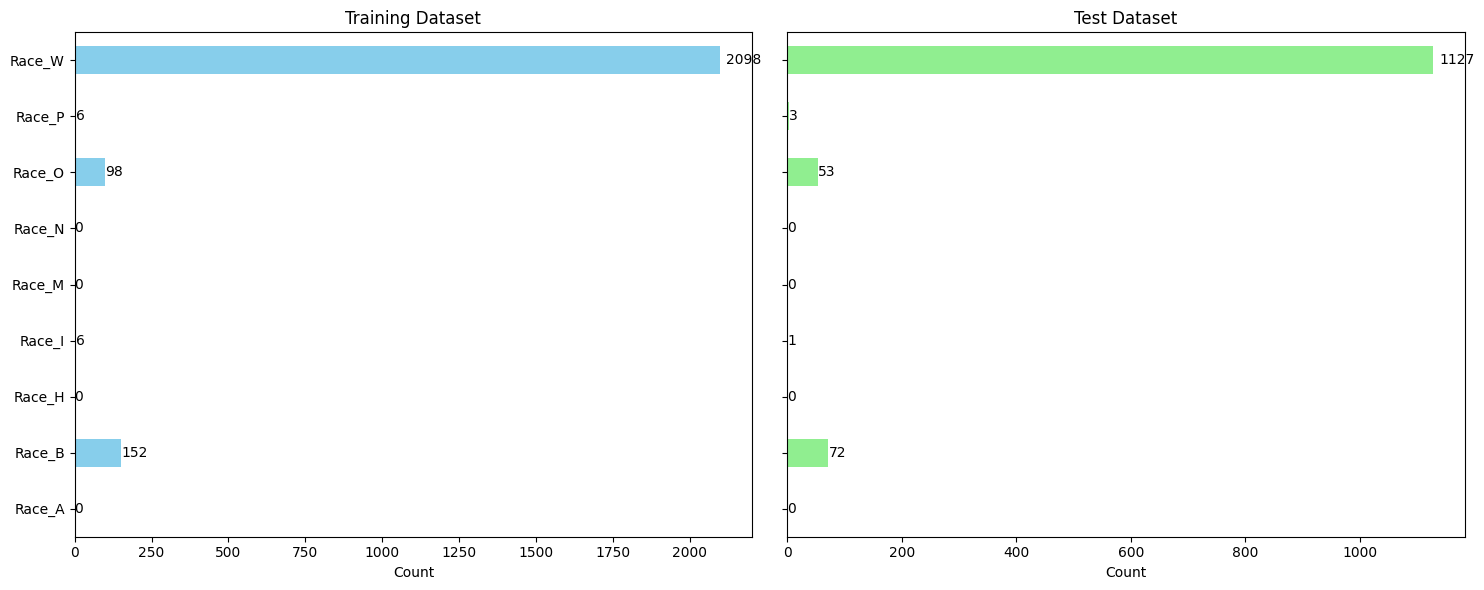

In [9]:
plot_dummy_var_counts(dfr, dft, ['Race_A','Race_B','Race_H','Race_I','Race_M','Race_N','Race_O','Race_P', 'Race_W'])

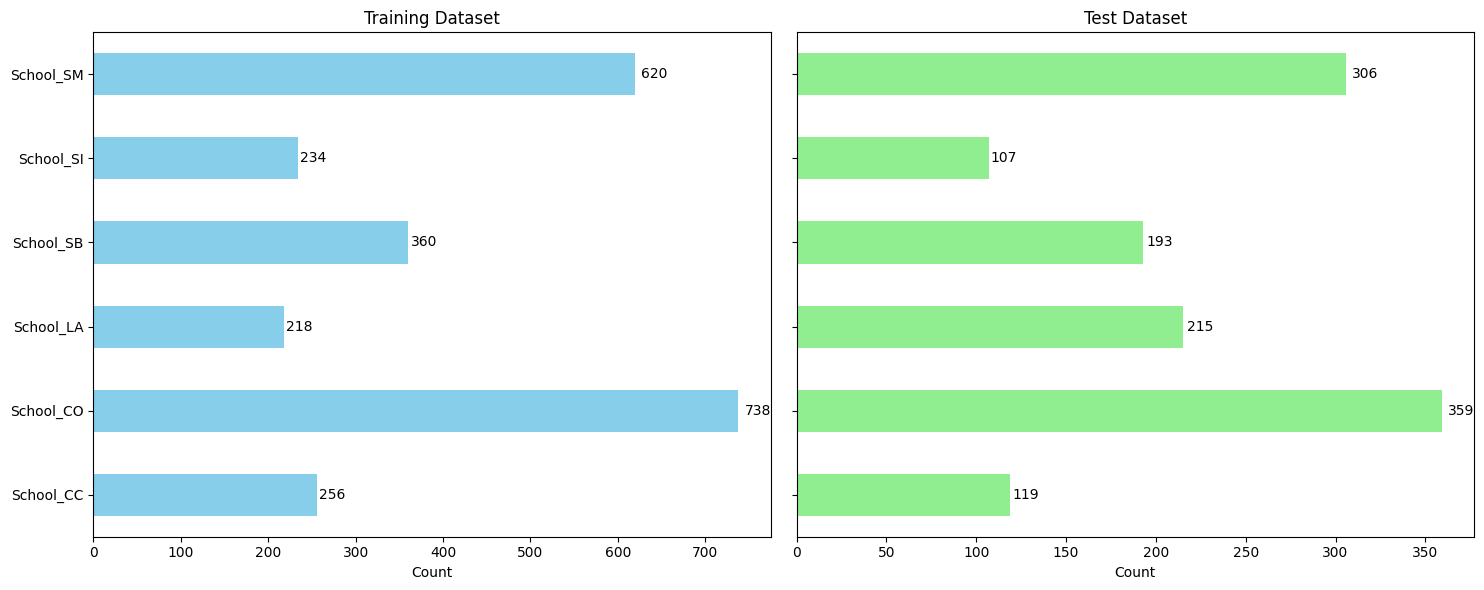

In [10]:
plot_dummy_var_counts(dfr, dft, ['School_CC', 'School_CO','School_LA','School_SB','School_SI','School_SM'])

## Exclude features

In [125]:
## remove features here ex1 and ex[n] are used to create exclude_always
# just to keep things organized
#

ex1 = ['Mid_Fall_GPA', 'Mid_Fall_Cred_Regstr', 'HSClassPercentile'] # , 'OCCUPANTS_BLDG''HSClassPercentile', 'APTITUDE_SCORE'
ex2 = ['PP_GPA', 'PP_Involve', 'PP_Rm_Cond', 'PP_Rm_Damg', 'PP_Dscpln', 'PP_Other']
# from augmented data, generalized by zip code
ex3 = ['percentHigherEd', 'giniIndex', 'medianIncome', 'percentWithInternet','percentMinority']
ex4 = ['APTITUDE_SCORE']
exclude_always = ex1 + ex2 + ex3 + ex4


if (semester==1) :   # exclude first smester GPA
   excluded_fields = ['AttritFall','AttritSpring', 'Attrited', 'FS_GPA_NUM' ] + exclude_always
if (semester == 2) : # filter those gone after first semester
  dfr  = dfr[dfr.AttritFall!= 1]
  dft  = dft[dft.AttritFall!= 1]
  excluded_fields = ['AttritFall','AttritSpring', 'Attrited'] + exclude_always

#X_train, y_train =dfr.drop(excluded_fields, axis=1), dfr[['AttritFall']].values.flatten()
#X_test, y_test =dft.drop(excluded_fields, axis=1), dft[['AttritFall']].values.flatten()

X_train, y_train =dfr.drop(excluded_fields, axis=1), dfr[['Attrited']]
X_test, y_test =dft.drop(excluded_fields, axis=1), dft[['Attrited']]


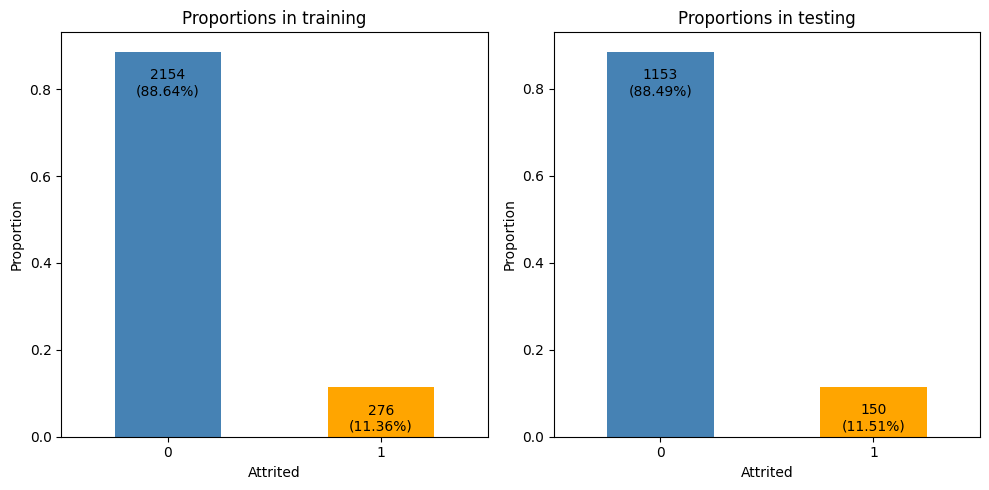

In [354]:
plot_binary_distributions(y_train, y_test)

In [13]:
X_train

,EarlyAction,EarlyDecision,MeritScholAmt,FinAidRating,HSTier,Foreign,FAFSA,APCourses,Male,Minority,...,Race_N,Race_O,Race_P,isPellRecipient,ISDEANSLIST,ISPROBATION,OCCUPANTS_BLDG,OCCUPANTS_ROOM,IS_SINGLE_ROOM,IS_UNLIMITED_MEAL_PLAN
0,0,0,0,NaN,3,0,0,1,1,0,...,0,0,0,0,0,0,NaN,NaN,0,0
1,0,0,10,NaN,2,0,0,1,0,0,...,0,0,0,0,0,0,NaN,NaN,0,0
2,0,1,0,7.0,3,0,0,1,0,0,...,0,0,0,0,0,0,157.0,3.0,0,1
3,0,1,0,7.0,2,0,0,1,0,0,...,0,0,0,0,0,0,147.0,2.0,0,1
4,0,0,0,9.0,1,0,1,0,0,0,...,0,0,0,1,0,0,25.0,25.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,0,0,0,8.0,3,0,1,0,0,0,...,0,0,0,0,0,0,365.0,3.0,0,1
2426,1,0,0,7.0,3,0,0,0,1,0,...,0,0,0,0,0,0,157.0,5.0,0,1
2427,0,0,0,9.0,2,1,0,0,1,0,...,0,0,0,0,0,0,421.0,2.0,0,1
2428,0,0,0,9.0,1,1,0,0,1,1,...,0,0,0,0,0,0,NaN,NaN,0,0


In [14]:
print(f'training shape:{dfr.shape} ,test shape:{dft.shape}')

training shape:(2430, 58) ,test shape:(1303, 58)


## Show Null Values

<Axes: >

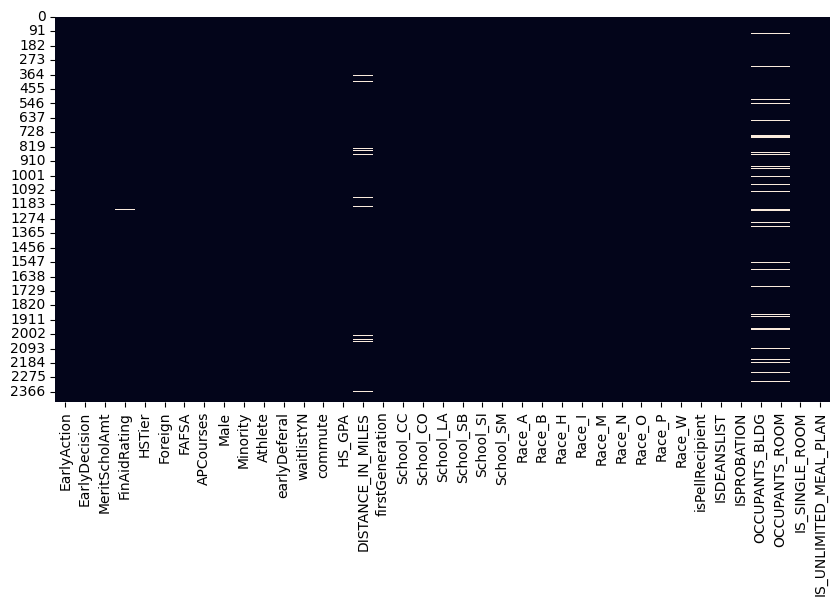

In [127]:
sns.heatmap(X_train.isnull(), cbar=False)

# Impute Data

In [129]:
#df_types = {'EarlyAction': 'b', 'EarlyDecision': 'b', 'MeritScholAmt': 'f', 'FinAidRating': 'f', 'HSTier': 'c', 'Foreign': 'b',
# 'FAFSA': 'b', 'APCourses': 'b', 'Male': 'b', 'Minority': 'b', 'Athlete': 'b', 'earlyDeferal': 'b', 'waitlistYN': 'b',
# 'commute': 'b', 'HS_GPA': 'f', 'DISTANCE_IN_MILES': 'f', 'APTITUDE_SCORE': 'f', 'firstGeneration': 'b', 'School_CC': 'b',
# 'School_CO': 'b', 'School_LA': 'b', 'School_SB': 'b', 'School_SI': 'b', 'School_SM': 'b', 'Race_A': 'b', 'Race_B': 'b',
# 'Race_H': 'b', 'Race_I': 'b', 'Race_M': 'b', 'Race_N': 'b', 'Race_O': 'b', 'Race_P': 'b', 'Race_W': 'b', 'isPellRecipient': 'b',
# 'ISDEANSLIST': 'b', 'ISPROBATION': 'b', 'OCCUPANTS_BLDG': 'f', 'OCCUPANTS_ROOM': 'f', 'IS_SINGLE_ROOM': 'b', 'IS_UNLIMITED_MEAL_PLAN': 'b'}

df_types = {'EarlyAction': 'b', 'EarlyDecision': 'b', 'MeritScholAmt': 'f', 'FinAidRating': 'f', 'HSTier': 'c', 'Foreign': 'b',
 'FAFSA': 'b', 'APCourses': 'b', 'Male': 'b', 'Minority': 'b', 'Athlete': 'b', 'earlyDeferal': 'b', 'waitlistYN': 'b',
 'commute': 'b', 'HS_GPA': 'f', 'DISTANCE_IN_MILES': 'f', 'firstGeneration': 'b', 'School_CC': 'b', 'School_SM':'b',
 'School_CO': 'b', 'School_LA': 'b', 'School_SB': 'b', 'School_SI': 'b', 'Race_A': 'b', 'Race_B': 'b', 'Race_W':'b',
 'Race_H': 'b', 'Race_I': 'b', 'Race_M': 'b', 'Race_N': 'b', 'Race_O': 'b', 'Race_P': 'b', 'isPellRecipient': 'b',
 'ISDEANSLIST': 'b', 'ISPROBATION': 'b', 'OCCUPANTS_BLDG': 'f', 'OCCUPANTS_ROOM': 'f', 'IS_SINGLE_ROOM': 'b', 'IS_UNLIMITED_MEAL_PLAN': 'b'}

k_neighbors = 5
Xr_imputed  = CustomKNNImpute (X_train,df_types, k_neighbors)
Xt_imputed  = CustomKNNImpute (X_test,df_types, k_neighbors)


Imputing row 1/2430 with 3 missing, elapsed time: 2.404
Imputing row 101/2430 with 2 missing, elapsed time: 2.405
Imputing row 201/2430 with 0 missing, elapsed time: 2.406
Imputing row 301/2430 with 0 missing, elapsed time: 2.407
Imputing row 401/2430 with 0 missing, elapsed time: 2.408
Imputing row 501/2430 with 0 missing, elapsed time: 2.409
Imputing row 601/2430 with 0 missing, elapsed time: 2.410
Imputing row 701/2430 with 0 missing, elapsed time: 2.411
Imputing row 801/2430 with 0 missing, elapsed time: 2.412
Imputing row 901/2430 with 0 missing, elapsed time: 2.414
Imputing row 1001/2430 with 0 missing, elapsed time: 2.415
Imputing row 1101/2430 with 0 missing, elapsed time: 2.416
Imputing row 1201/2430 with 0 missing, elapsed time: 2.417
Imputing row 1301/2430 with 0 missing, elapsed time: 2.419
Imputing row 1401/2430 with 0 missing, elapsed time: 2.420
Imputing row 1501/2430 with 0 missing, elapsed time: 2.421
Imputing row 1601/2430 with 0 missing, elapsed time: 2.422
Imputing 

In [130]:
# Identify columns that contain only zeros
columns_with_zeros =[col for col in Xr_imputed.columns if Xr_imputed[col].eq(0).all()]
columns_with_zeros

['earlyDeferal', 'Race_A', 'Race_H', 'Race_M', 'Race_N']

In [131]:
Xr_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EarlyAction             2430 non-null   float64
 1   EarlyDecision           2430 non-null   float64
 2   MeritScholAmt           2430 non-null   float64
 3   FinAidRating            2430 non-null   float64
 4   HSTier                  2430 non-null   float64
 5   Foreign                 2430 non-null   float64
 6   FAFSA                   2430 non-null   float64
 7   APCourses               2430 non-null   float64
 8   Male                    2430 non-null   float64
 9   Minority                2430 non-null   float64
 10  Athlete                 2430 non-null   float64
 11  earlyDeferal            2430 non-null   float64
 12  waitlistYN              2430 non-null   float64
 13  commute                 2430 non-null   float64
 14  HS_GPA                  2430 non-null   

In [132]:
# Identify columns that contain only zeros
columns_with_zeros =[col for col in Xr_imputed.columns if Xr_imputed[col].eq(0).all()]
columns_with_zeros
X_trn_subset= Xr_imputed.drop(columns_with_zeros,axis=1)
X_tst_subset= Xt_imputed.drop(columns_with_zeros,axis=1)

In [ ]:
#, 'Race_W', 'School_SM']

In [133]:
X_trn_subset.columns

Index(['EarlyAction', 'EarlyDecision', 'MeritScholAmt', 'FinAidRating',
       'HSTier', 'Foreign', 'FAFSA', 'APCourses', 'Male', 'Minority',
       'Athlete', 'waitlistYN', 'commute', 'HS_GPA', 'DISTANCE_IN_MILES',
       'firstGeneration', 'School_CC', 'School_CO', 'School_LA', 'School_SB',
       'School_SI', 'School_SM', 'Race_B', 'Race_I', 'Race_O', 'Race_P',
       'Race_W', 'isPellRecipient', 'ISDEANSLIST', 'ISPROBATION',
       'OCCUPANTS_BLDG', 'OCCUPANTS_ROOM', 'IS_SINGLE_ROOM',
       'IS_UNLIMITED_MEAL_PLAN'],
      dtype='object')

In [134]:
X_tst_subset.columns

Index(['EarlyAction', 'EarlyDecision', 'MeritScholAmt', 'FinAidRating',
       'HSTier', 'Foreign', 'FAFSA', 'APCourses', 'Male', 'Minority',
       'Athlete', 'waitlistYN', 'commute', 'HS_GPA', 'DISTANCE_IN_MILES',
       'firstGeneration', 'School_CC', 'School_CO', 'School_LA', 'School_SB',
       'School_SI', 'School_SM', 'Race_B', 'Race_I', 'Race_O', 'Race_P',
       'Race_W', 'isPellRecipient', 'ISDEANSLIST', 'ISPROBATION',
       'OCCUPANTS_BLDG', 'OCCUPANTS_ROOM', 'IS_SINGLE_ROOM',
       'IS_UNLIMITED_MEAL_PLAN'],
      dtype='object')

In [20]:
subset = ['EarlyAction', 'EarlyDecision', 'MeritScholAmt', 'FinAidRating',
           'HSTier', 'Foreign', 'FAFSA', 'APCourses', 'Male', 'Minority',
           'Athlete', 'waitlistYN', 'commute',  'HS_GPA',
           'School_CC', 'School_CO','School_LA', 'School_SB', 'School_SI',
           'Race_A', 'Race_B', 'Race_H','Race_I', 'Race_M', 'Race_N', 'Race_O', 'Race_P',
           'DISTANCE_IN_MILES', 'firstGeneration','isPellRecipient',
           'ISDEANSLIST', 'ISPROBATION', 'OCCUPANTS_BLDG', 'OCCUPANTS_ROOM',
           'IS_SINGLE_ROOM', 'IS_UNLIMITED_MEAL_PLAN']

#X_trn_subset= Xr_imputed [subset]
#X_tst_subset= Xt_imputed [subset]

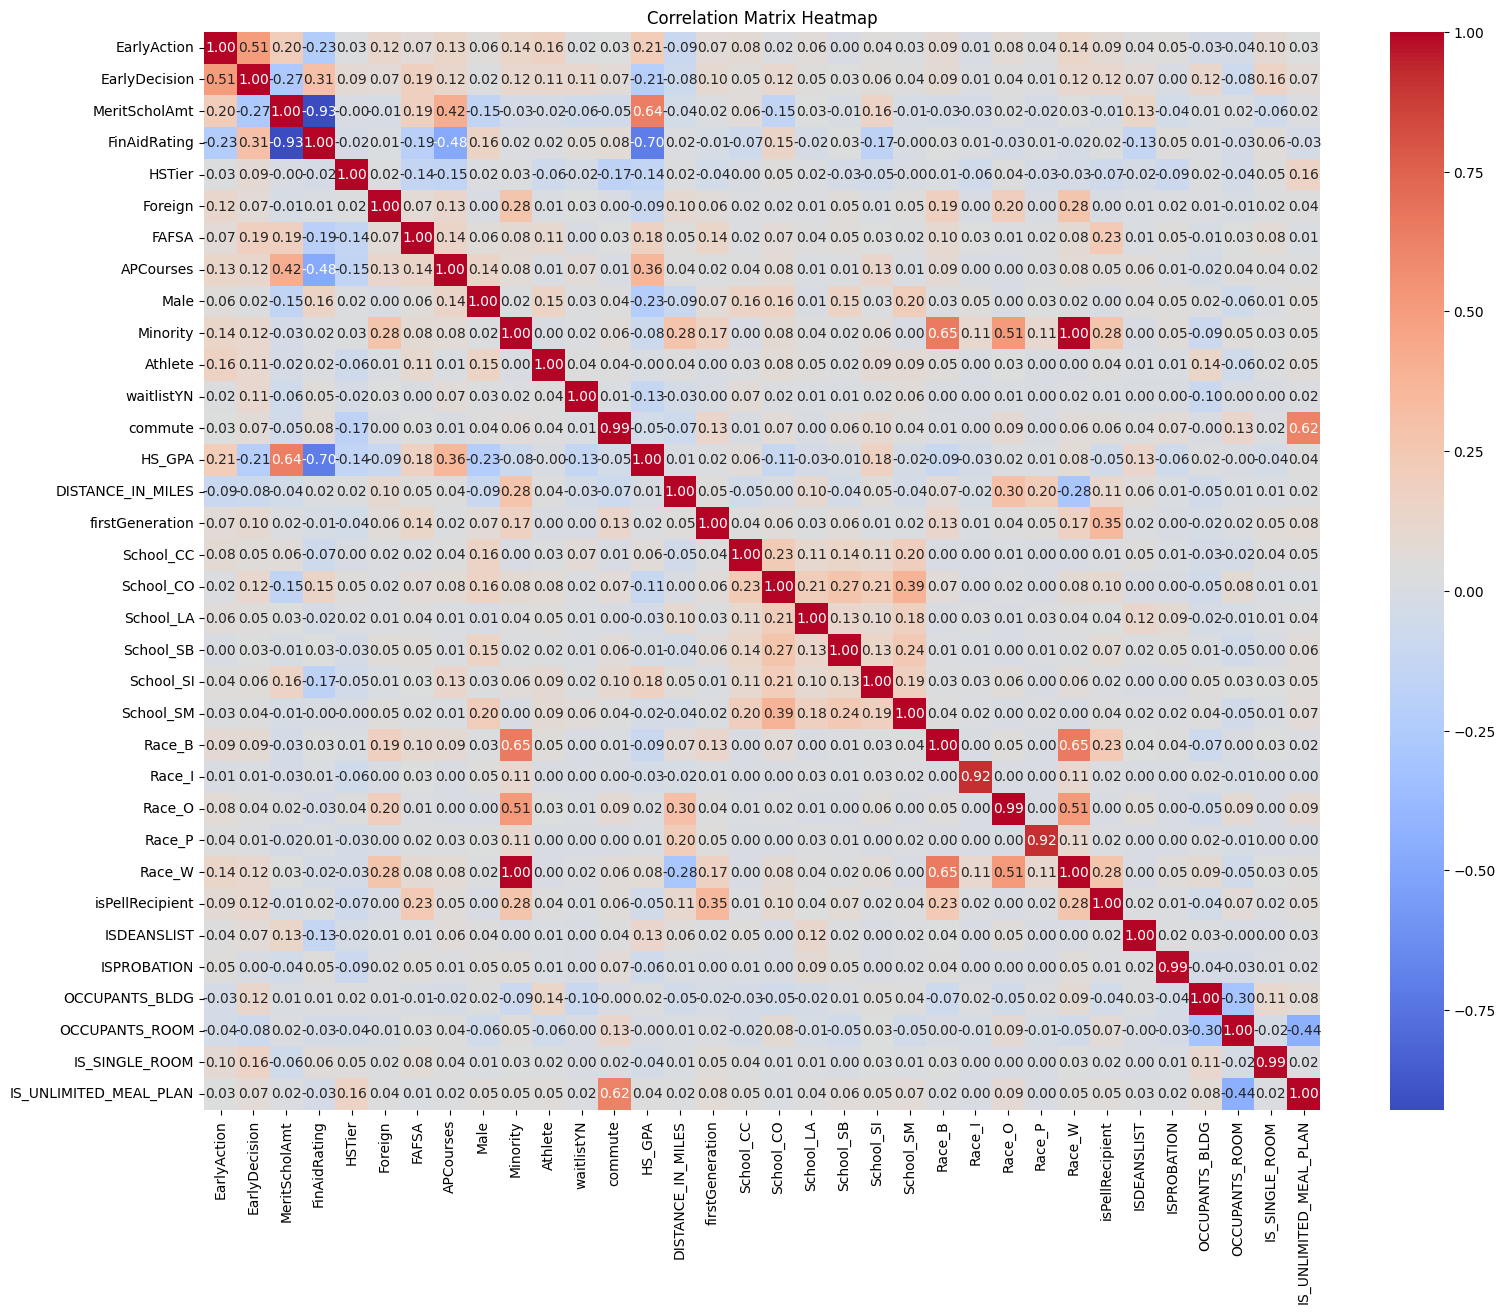

In [135]:
correlation_matrix = mixed_type_correlation_matrix(X_trn_subset)
correlation_matrix
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)  # Rotate x-axis labels vertically
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.title('Correlation Matrix Heatmap')
plt.show()

In [279]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_trn_subset)
scaled_Xtrain = pd.DataFrame(scaled_data, columns=X_trn_subset.columns)
scaled_Xtrain = scaled_Xtrain.drop(['Race_W', 'School_SM'], axis=1)

clf = LogisticRegressionStatsModel(scaled_Xtrain.columns, "Attrited")
selected_features = clf.fit(scaled_Xtrain, y_train, method='bfgs', maxiter=500, stepwise=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.278364
         Iterations: 60
         Function evaluations: 61
         Gradient evaluations: 61


In [280]:
clf.check_convergence()

True

In [281]:
clf.get_mle_retvals()

{'fopt': 0.2783644740384611,
 'gopt': array([ 1.30097382e-06,  1.64734188e-06, -9.30126147e-06,  7.56309748e-06,
        -1.45310829e-06,  8.49407078e-07, -2.27678847e-06, -5.06262268e-06]),
 'Hinv': array([[ 28.52616262,  -3.92681153, -19.60127775, -10.65186935,
         -10.77568725, -38.60237286,  -4.99237317,   6.55719161],
        [ -3.92681153, 125.21101737,  -0.86653779,  20.16709212,
           0.77575128, -51.01157437,  16.69178594,   6.49950673],
        [-19.60127775,  -0.86653779, 165.3362393 , 134.2995782 ,
          -5.4895322 ,   6.54971411,  14.07507981, -35.47084407],
        [-10.65186935,  20.16709212, 134.2995782 , 170.86950116,
         -35.80473254,  10.96688802, -38.52399718, -21.51238055],
        [-10.77568725,   0.77575128,  -5.4895322 , -35.80473254,
          85.62402808,  -6.13949868,   9.12242259, -28.84611457],
        [-38.60237286, -51.01157437,   6.54971411,  10.96688802,
          -6.13949868, 165.06726692, -26.81125334,  16.719471  ],
        [ -4.99

In [282]:
# Get the top summary and coefficient summary
logreg_summary = clf.get_summary()
coef_summary = clf.get_coef_summary()
# Print the top the summary, Transpose it for better viz.
print(logreg_summary.transpose())
# Print the coefficient summary
coef_summary.reset_index()

                                   0
Dep. Variable               Attrited
No. Observations                2430
Method                           MLE
Model                          Logit
Df Residuals               2422.0000
Chi-Square                  367.2769
Chi-Square p-value            0.0000
Df Model (Chi-Square Test)    7.0000
Pseudo R-squ.                 0.2135
Log-Likelihood             -676.4257
LL-Null                    -860.0641
LLR p-value                   0.0000
AIC                        1368.8513
converged                       True


,index,Coefficient Value,Standard Error,Wald Test Chi2,Wald Test P>|Chi2|,Odds Ratio
0,const,-2.2878,0.1145,399.4576,0.0000,0.1015
1,ISDEANSLIST,3.5969,0.2507,205.8898,0.0000,36.4864
2,DISTANCE_IN_MILES,1.9872,0.3754,28.0234,0.0000,7.2950
3,ISPROBATION,1.7522,0.3578,23.9755,0.0000,5.7670
4,School_LA,1.0657,0.2009,28.1336,0.0000,2.9028
5,MeritScholAmt,-1.5406,0.2739,31.6310,0.0000,0.2142
6,School_SI,1.0439,0.2231,21.9037,0.0000,2.8403
7,Athlete,-1.2782,0.3198,15.9698,0.0001,0.2785


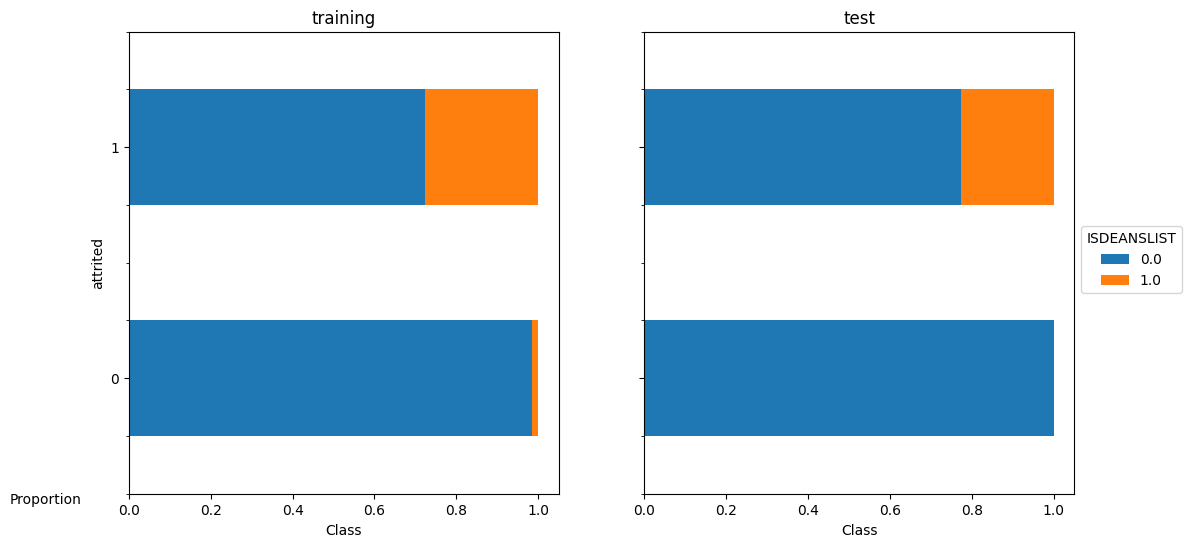

In [28]:
plot_overlayed_proportions(y_train.squeeze(), y_test.squeeze(), 'ISDEANSLIST', Xr_imputed, Xt_imputed)

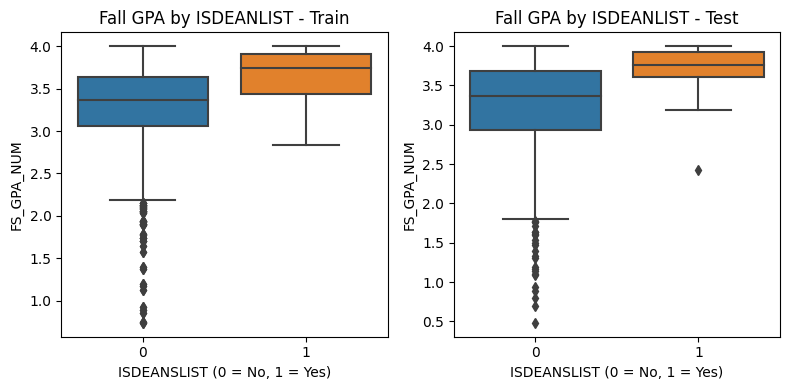

In [29]:
plot_boxplots(dfr, dft, 'ISDEANSLIST', 'FS_GPA_NUM', ['Fall GPA by ISDEANLIST - Train','Fall GPA by ISDEANLIST - Test'])

# Predict on Test Set

In [141]:
scaled_data = scaler.transform(X_tst_subset)
scaled_Xtest = pd.DataFrame(scaled_data, columns=X_tst_subset.columns)
scaled_Xtest = scaled_Xtest.drop(['Race_W', 'School_SM'], axis=1)

# Predict using the test data
probs_test = clf.predict_proba(scaled_Xtest[selected_features])
y_test_pred = clf.predict(scaled_Xtest[selected_features])

In [142]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix,roc_curve, auc

In [143]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1153
           1       0.84      0.24      0.37       150

    accuracy                           0.91      1303
   macro avg       0.87      0.62      0.66      1303
weighted avg       0.90      0.91      0.88      1303





Accuracy.........: 90.7137
Precision........: 83.7209
Recall...........: 24.0000
FP Rate..........: 0.6071
ROC AUC (probs)..: 0.7809
F1 measure.......: 0.3731
Confusion matrix.:
 [[1146    7]
 [ 114   36]]


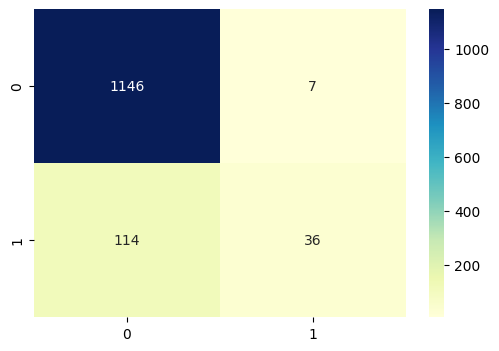

In [33]:
# Report the predictive performance metrics
# evaluate predictions
accuracy = accuracy_score(y_test, y_test_pred)
precision=precision_score(y_test, y_test_pred, pos_label=1)
recall=recall_score(y_test, y_test_pred, pos_label=1)
f1 = f1_score(y_test, y_test_pred, pos_label=1)
specificity=recall_score(y_test, y_test_pred, pos_label=0)
roc = roc_auc_score(y_test, probs_test )

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate..........: {(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc :.4f}")
print(f"F1 measure.......: {f1 :.4f}")

cm = confusion_matrix(y_test, y_test_pred)
print(f"Confusion matrix.:\n {cm}")

#This is nicer
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

In [34]:
fpr, tpr, threshold = roc_curve(y_test, probs_test)
roc_auc = auc(fpr, tpr)
roc_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': threshold})
roc_df

,tpr,fpr,threshold
0,0.0000,0.0000,1.9301
1,0.0067,0.0000,0.9301
2,0.0667,0.0000,0.8063
3,0.0667,0.0009,0.7847
4,0.1867,0.0009,0.6485
...,...,...,...
189,0.9867,0.9003,0.0182
190,0.9933,0.9003,0.0179
191,0.9933,0.9948,0.0046
192,1.0000,0.9948,0.0043


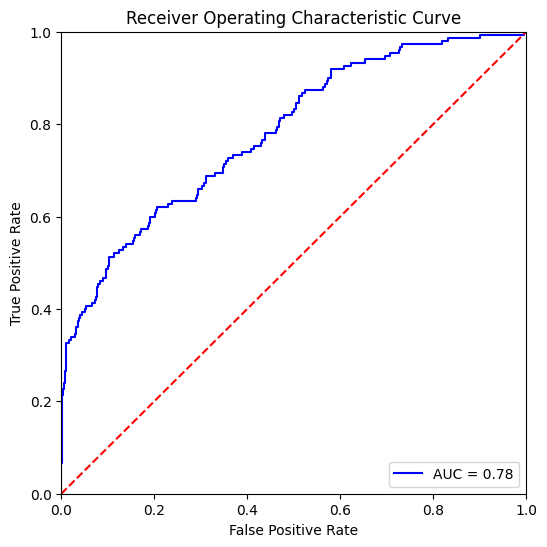

In [35]:
# Create a square figure
plt.figure(figsize=(6, 6))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('ROCcuve.png')
plt.show()

# Show Optimal Cutoffs

In [36]:
#Idenfity appropriate threshold
#roc_df.loc[roc_df.tpr>0.30 & roc_df.tpr <0.40]
#roc_df.loc[(roc_df.fpr<0.1)]
roc_df[roc_df.tpr>0.40]

,tpr,fpr,threshold
38,0.4067,0.0538,0.2431
39,0.4067,0.0650,0.2248
40,0.4133,0.0650,0.2232
41,0.4133,0.0729,0.2150
42,0.4200,0.0729,0.2142
...,...,...,...
189,0.9867,0.9003,0.0182
190,0.9933,0.9003,0.0179
191,0.9933,0.9948,0.0046
192,1.0000,0.9948,0.0043


In [37]:
# make predictions for test data
#predictions = model.predict(X_test,ntree_limit=model.best_ntree_limit)  # not using it to vary the threshold

# Confusion Matrix



Accuracy.........: 88.0276
Precision........: 47.6562
Recall...........: 40.6667
FP Rate..........: 5.8109
ROC AUC (probs)..: 0.7809
F1 measure.......: 0.4388
Confusion matrix.:
 [[1146    7]
 [ 114   36]]


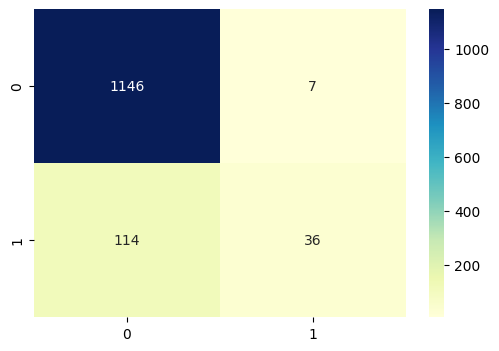

In [38]:
cutoff = 0.23 # picked from above
predictions = (probs_test >cutoff).astype(int)

# Report the predictive performance metrics
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions, pos_label=1)
recall=recall_score(y_test, predictions, pos_label=1)
f1 = f1_score(y_test, predictions, pos_label=1)
specificity=recall_score(y_test, predictions, pos_label=0)
roc = roc_auc_score(y_test, probs_test )

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate..........: {(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc :.4f}")
print(f"F1 measure.......: {f1 :.4f}")

cm = confusion_matrix(y_test, y_test_pred)
print(f"Confusion matrix.:\n {cm}")

#This is nicer
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

## Analysis by School

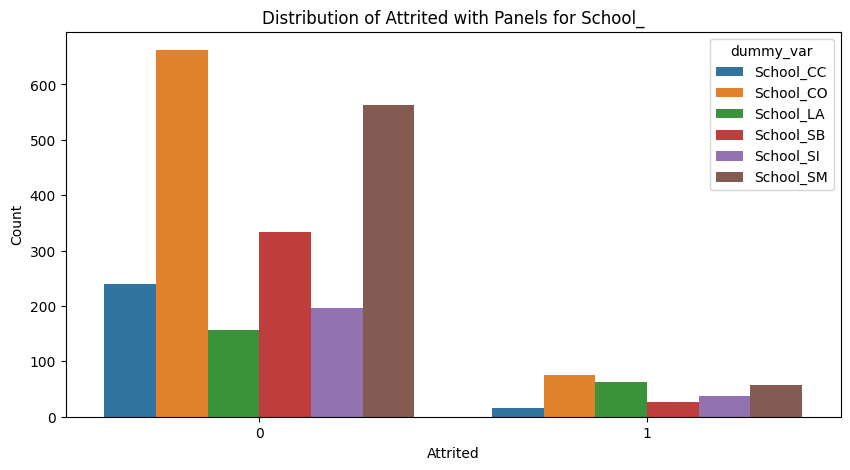

In [39]:
plot_binary_distribution_with_dummies(dfr, "Attrited", "School_")

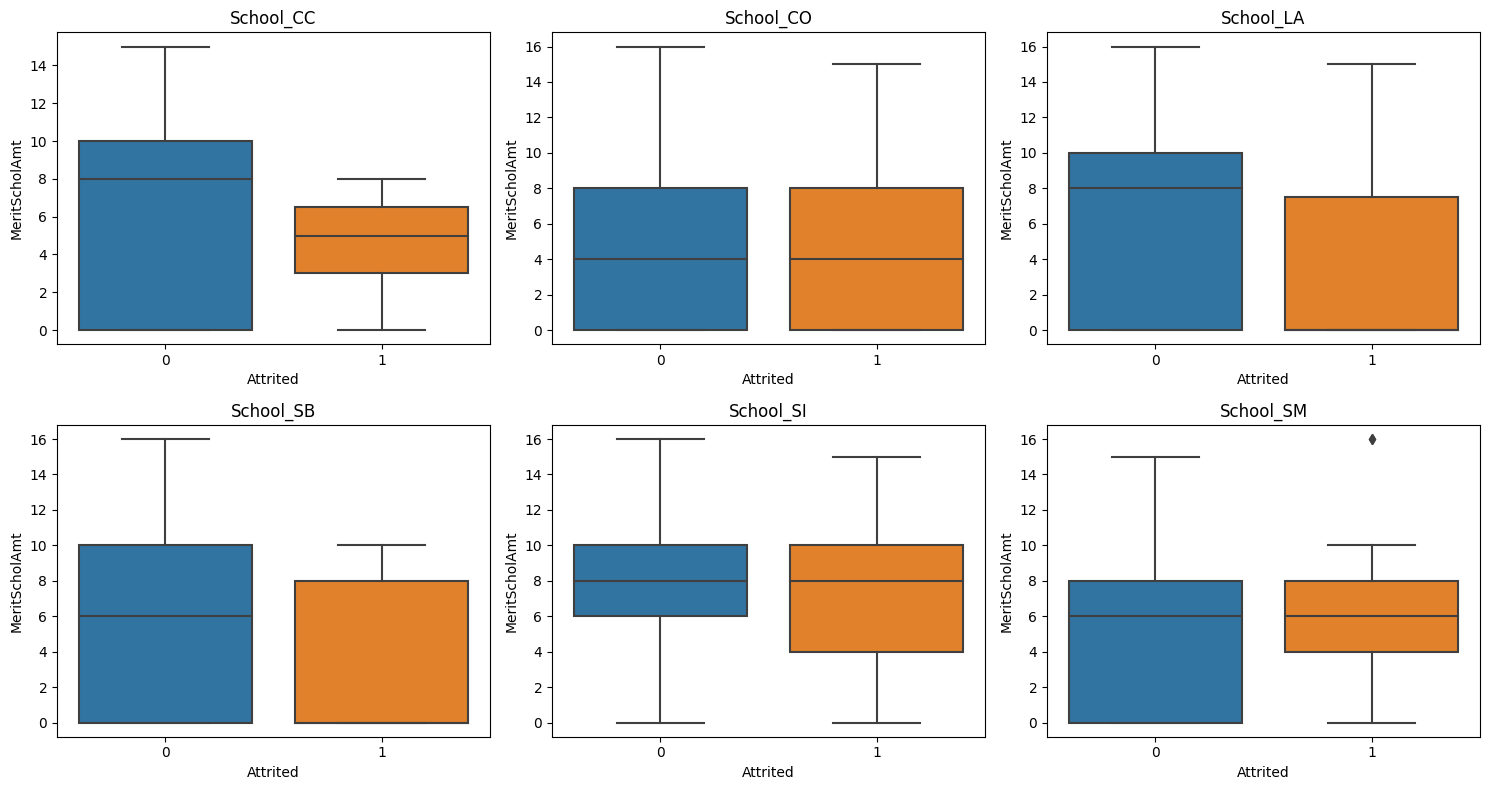

In [40]:
plot_school_attrition_boxplots(dfr, "MeritScholAmt")

In [41]:
anova_results=perform_anova_for_schools(dfr, "MeritScholAmt")
for k in anova_results:
    print(f'{k}:\n{anova_results[k]}\n')


School_CC:
               sum_sq       df      F  PR(>F)
C(Attrited)   53.6760   1.0000 1.8818  0.1713
Residual    7245.1833 254.0000    NaN     NaN

School_CO:
                sum_sq       df      F  PR(>F)
C(Attrited)     4.7269   1.0000 0.2357  0.6274
Residual    14757.2244 736.0000    NaN     NaN

School_LA:
               sum_sq       df       F  PR(>F)
C(Attrited)  335.5757   1.0000 13.2524  0.0003
Residual    5469.5252 216.0000     NaN     NaN

School_SB:
               sum_sq       df      F  PR(>F)
C(Attrited)   78.0440   1.0000 3.2851  0.0707
Residual    8505.0115 358.0000    NaN     NaN

School_SI:
               sum_sq       df      F  PR(>F)
C(Attrited)   22.5713   1.0000 1.1759  0.2793
Residual    4453.0526 232.0000    NaN     NaN

School_SM:
                sum_sq       df      F  PR(>F)
C(Attrited)    21.4819   1.0000 1.0212  0.3126
Residual    12999.8665 618.0000    NaN     NaN



In [76]:
        '''  ‘newton’ for Newton-Raphson,
             ‘nm’ for Nelder-Mead
             ‘bfgs’ for Broyden-Fletcher-Goldfarb-Shanno (BFGS)
             ‘lbfgs’ for limited-memory BFGS with optional box constraints
             ‘powell’ for modified Powell’s method
             ‘cg’ for conjugate gradient
             ‘ncg’ for Newton-conjugate gradient
             ‘basinhopping’ for global basin-hopping solver
             ‘minimize’ for generic wrapper of scipy minimize (BFGS by default)
        '''

'  ‘newton’ for Newton-Raphson,\n     ‘nm’ for Nelder-Mead\n     ‘bfgs’ for Broyden-Fletcher-Goldfarb-Shanno (BFGS)\n     ‘lbfgs’ for limited-memory BFGS with optional box constraints\n     ‘powell’ for modified Powell’s method\n     ‘cg’ for conjugate gradient\n     ‘ncg’ for Newton-conjugate gradient\n     ‘basinhopping’ for global basin-hopping solver\n     ‘minimize’ for generic wrapper of scipy minimize (BFGS by default)\n'

In [148]:
X_trn_subset.columns.values

array(['EarlyAction', 'EarlyDecision', 'MeritScholAmt', 'FinAidRating',
       'HSTier', 'Foreign', 'FAFSA', 'APCourses', 'Male', 'Minority',
       'Athlete', 'waitlistYN', 'commute', 'HS_GPA', 'DISTANCE_IN_MILES',
       'firstGeneration', 'School_CC', 'School_CO', 'School_LA',
       'School_SB', 'School_SI', 'School_SM', 'Race_B', 'Race_I',
       'Race_O', 'Race_P', 'Race_W', 'isPellRecipient', 'ISDEANSLIST',
       'ISPROBATION', 'OCCUPANTS_BLDG', 'OCCUPANTS_ROOM',
       'IS_SINGLE_ROOM', 'IS_UNLIMITED_MEAL_PLAN'], dtype=object)

In [332]:
subset=['MeritScholAmt', 'HSTier','Male', 'Minority',
        'Athlete', 'HS_GPA', 'DISTANCE_IN_MILES',
        'ISDEANSLIST', 'ISPROBATION']

In [348]:
feature = 'School_SI'
discrete_var_prefix= 'School_'
dummy_vars = [col for col in X_trn_subset.columns if col.startswith(discrete_var_prefix)]
filtered_X = X_trn_subset[X_trn_subset[feature] == 1].drop(dummy_vars,axis=1)
filtered_y = y_train.iloc[filtered_X.index].reset_index(drop=True)

scaled_X = scale_dataframe(filtered_X[subset]).reset_index(drop=True)
clf = LogisticRegressionStatsModel(scaled_X.columns, "Attrited")
selected_features = clf.fit(scaled_X, filtered_y, method='minimize', maxiter=1000, stepwise=False)

Optimization terminated successfully.
         Current function value: 0.293974
         Iterations: 90
         Function evaluations: 91
         Gradient evaluations: 91


In [346]:
clf.get_mle_retvals()

{'fopt': 0.3992605215318682,
 'iterations': 68,
 'fcalls': 69,
 'warnflag': 0,
 'converged': True}

In [349]:
# Get the top summary and coefficient summary
logreg_summary = clf.get_summary()
coef_summary = clf.get_coef_summary()
# Print the top the summary, Transpose it for better viz.
print(logreg_summary.transpose())
# Print the coefficient summary
coef_summary.reset_index()

                                   0
Dep. Variable               Attrited
No. Observations                 234
Method                           MLE
Model                          Logit
Df Residuals                224.0000
Chi-Square                   70.0328
Chi-Square p-value            0.0000
Df Model (Chi-Square Test)    9.0000
Pseudo R-squ.                 0.3373
Log-Likelihood              -68.7900
LL-Null                    -103.8064
LLR p-value                   0.0000
AIC                         157.5800
converged                       True


,index,Coefficient Value,Standard Error,Wald Test Chi2,Wald Test P>|Chi2|,Odds Ratio
0,const,0.6954,0.6986,0.9906,0.3196,2.0044
1,MeritScholAmt,-0.7438,1.2311,0.3650,0.5458,0.4753
2,HSTier,-1.3899,0.7040,3.8977,0.0484,0.2491
3,Male,-0.3924,0.4993,0.6177,0.4319,0.6754
4,Minority,-0.1587,0.6355,0.0624,0.8028,0.8533
5,Athlete,-19.5924,6314.6594,0.0000,0.9975,0.0000
6,HS_GPA,-2.0935,1.2512,2.7996,0.0943,0.1233
7,DISTANCE_IN_MILES,1.0935,1.1883,0.8467,0.3575,2.9846
8,ISDEANSLIST,44.6385,94879.8762,0.0000,0.9996,24335421213033725952.0000
9,ISPROBATION,0.6575,1.2236,0.2887,0.5910,1.9300


In [269]:

def plot_binary_vars_vs_attrited__by_school(dfr, attrited_var, bin_var):
  # List of school columns
  discrete_var_prefix= 'School_'
  school_columns = [col for col in dfr.columns if col.startswith(discrete_var_prefix)]

  # Initialize a DataFrame to store aggregated data
  aggregated_data = []

  # Process each school
  for school in school_columns:
    # Filter data for students in the school who are attrited
    school_df = dfr[(dfr[school] == 1) & (dfr[attrited_var] == 1)]

    # Calculate proportions
    total_attrited = len(school_df)
    bin_var_1_count = school_df[bin_var].sum()
    bin_var_0_count = total_attrited - bin_var_1_count

    # Normalize to get proportions
    bin_var_1_prop = bin_var_1_count / total_attrited if total_attrited > 0 else 0
    bin_var_0_prop = bin_var_0_count / total_attrited if total_attrited > 0 else 0

    # Append to DataFrame
    aggregated_data.append({'School': school, bin_var+'= 1': bin_var_1_prop, bin_var+'= 0': bin_var_0_prop})

  # Convert list of dictionaries to DataFrame
  aggregated_data_df = pd.DataFrame(aggregated_data)

  # Plotting
  ax = aggregated_data_df.set_index('School').plot(kind='barh', stacked=True, figsize=(10, 6))
  plt.title(f'Proportion of Attrited Students by {bin_var} in Each School')
  plt.xlabel('Proportion of Attrited Students')
  plt.ylabel('School')

  # Moving the legend outside of the plot
  plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.show()



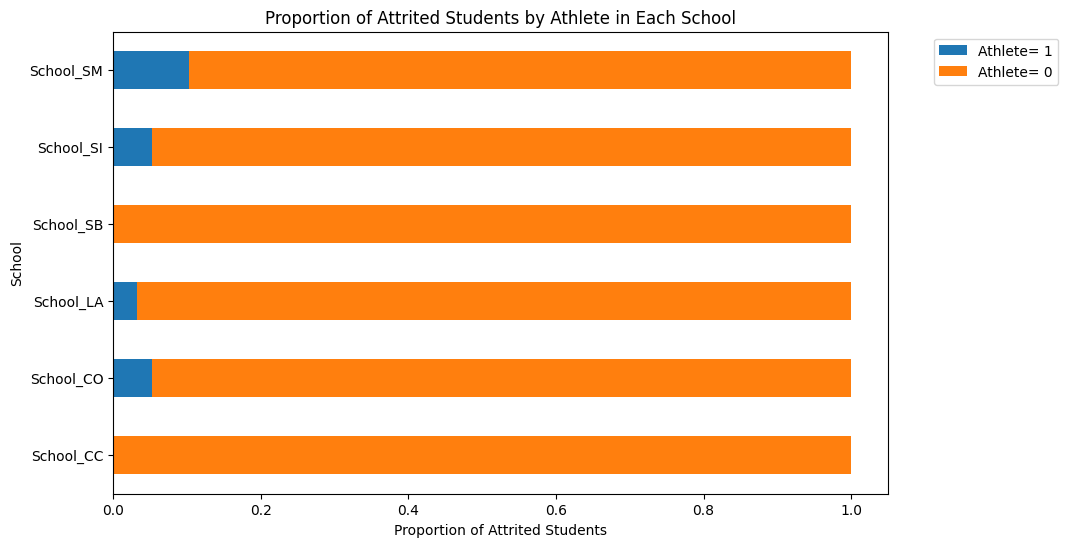

In [277]:
plot_binary_vars_vs_attrited__by_school(dfr, 'Attrited', 'Athlete')

In [278]:
chi_square_test_by_school(dfr, 'Attrited', 'Athlete')

,School,Chi-Square Statistic,p-value,Degrees of Freedom
0,School_CC,0.6498,0.4202,1
1,School_CO,0.3358,0.5623,1
2,School_LA,0.8234,0.3642,1
3,School_SB,1.8537,0.1734,1
4,School_SI,5.4021,0.0201,1
5,School_SM,1.1460,0.2844,1
